In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import dama as dm
%load_ext autoreload
%autoreload 2
from scipy import optimize
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
%matplotlib inline
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 24,
          'axes.titlesize': 24,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

# Building a detector

In [194]:
from detectors import get_box_detector, get_spherical_detector

In [195]:
detector = get_box_detector()

In [226]:
detector = get_spherical_detector()

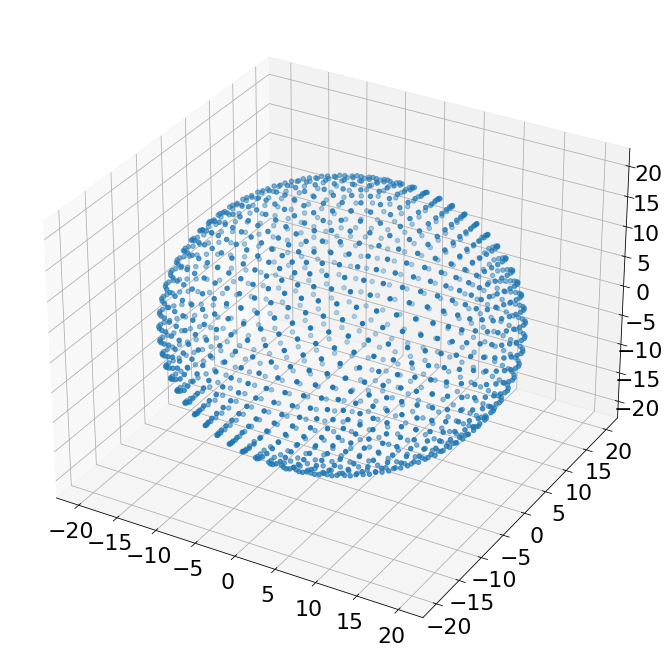

In [227]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d', )

ax.scatter(detector[:,0], detector[:,1], detector[:,2], )

In [228]:
from toy_model_functions import toy_model
model = toy_model(detector)

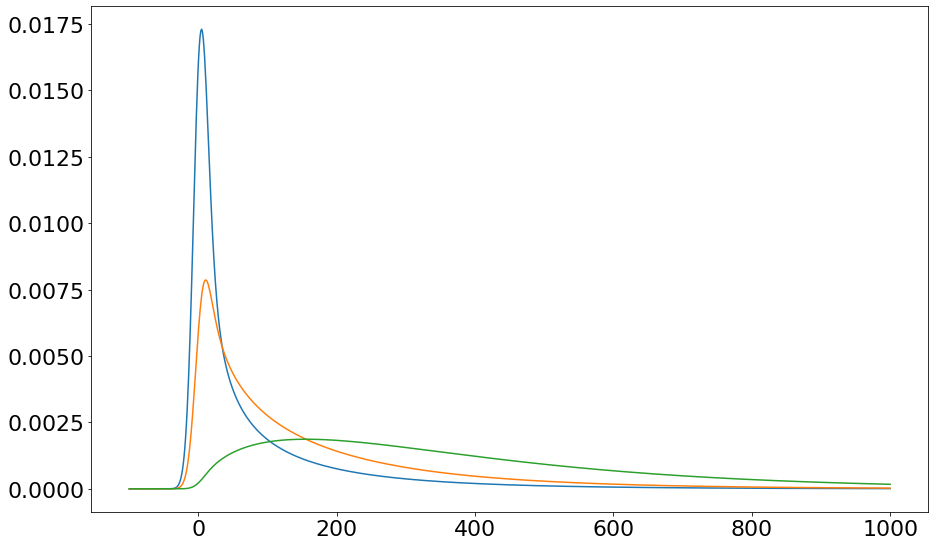

In [229]:
ts = np.linspace(-100, 1000, 1000)
plt.plot(ts, model.pandel.pdf(ts, d=10))
plt.plot(ts, model.pandel.pdf(ts, d=20))
plt.plot(ts, model.pandel.pdf(ts, d=50))

In [246]:
#truth = [7., -13., 55, -37, 5.73, 0.85, 23, 8]
truth = [0., -1., 10, -3, 2, 0.85, 1, 10]
hits, n_obs = model.generate(truth)

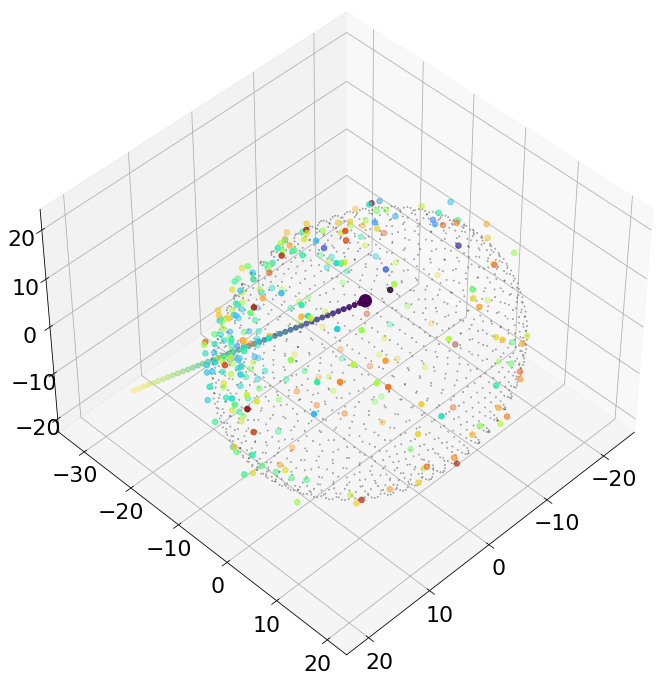

In [247]:
# Visualize

segments = model.model(*truth)
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c=segments[:,3])
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)

In [248]:
%%time
d = dm.GridData(x = np.linspace(-100, 100, 30), y=np.linspace(-100, 100, 30))
llhs = []
p = np.copy(truth)

for x, y in tqdm(zip(d.x.flat(), d.y.flat())):
    p[0] = x
    p[1] = y
    llhs.append(model.nllh(p, hits, n_obs))

d.llh = np.array(llhs).reshape(d.shape)

900it [00:06, 146.29it/s]

CPU times: user 6.18 s, sys: 1.44 ms, total: 6.18 s
Wall time: 6.15 s


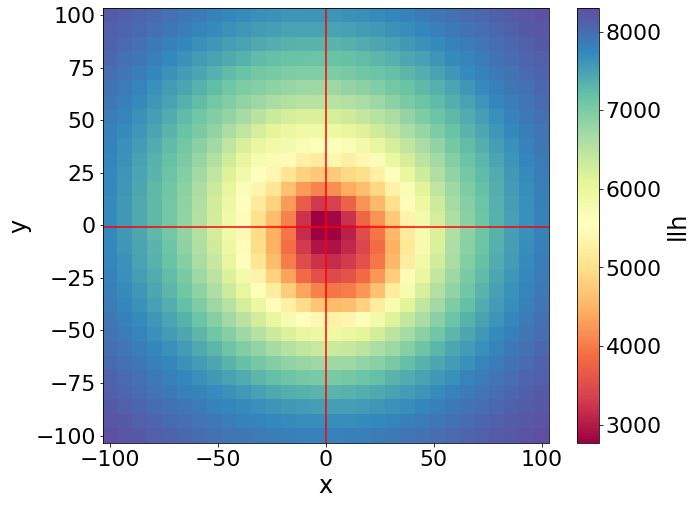

In [249]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

d.plot(cmap="Spectral", cbar=True)
plt.gca().axvline(truth[0], c='r')
plt.gca().axhline(truth[1], c='r')

In [250]:
%%time
d1 = dm.GridData(y=np.linspace(-100, 100, 100))
llhs = []
llhs2 = []
p = np.copy(truth)
for y in tqdm(d1.y):
    p[1] = y
    llhs.append(model.nllh(p, hits, n_obs))
    llhs2.append(model.nllh_formulation2(p, hits, n_obs))
d1.llh = np.array(llhs)
d1.llh2 = np.array(llhs2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.89it/s]

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.79 s


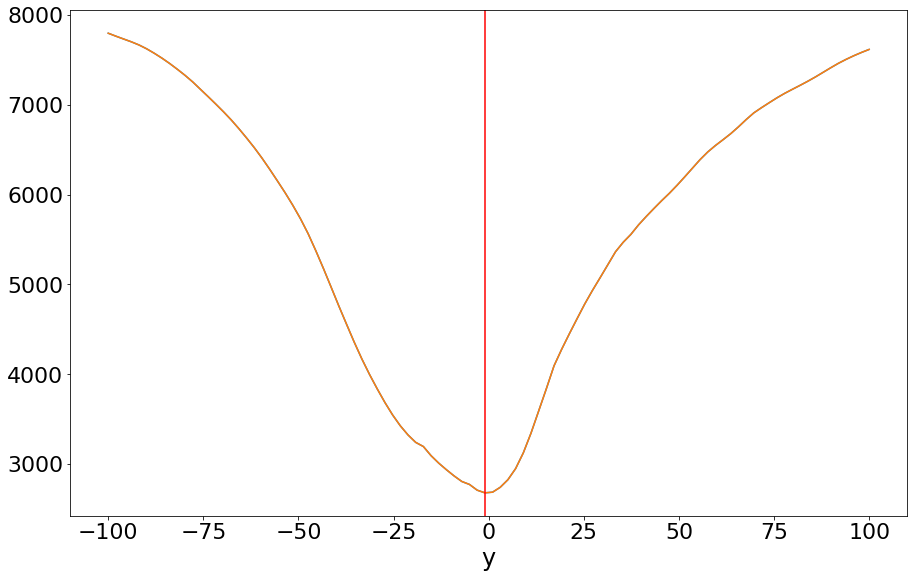

In [251]:
d1.llh.plot()
d1.llh2.plot()
plt.axvline(truth[1], c='r')

# Reco test

In [752]:
from spherical_opt import spherical_opt

In [765]:
x0 = np.random.rand(30, 8)

x0[:, :2] *= 100
x0[:, :2] -= 50
x0[:, 2] *= 300
x0[:, 2] -= 200
x0[:, 3] *= 200
x0[:, 3] -= 100
x0[:, 4] *= 2*np.pi
x0[:, 5] *= np.pi
x0[:, 6:] *= 2

In [766]:
res = spherical_opt.spherical_opt(lambda x : nllh(np.concatenate([x[:6], np.exp(x[6:])]), hits, detector), method='CRS2', spherical_indices=[(4,5),], initial_points=x0, )

In [767]:
reco = np.concatenate([res['x'][:6], np.exp(res['x'][6:])])

In [768]:
nllh(reco, hits, detector)

364.91510529878235

In [769]:
nllh(truth, hits, detector)

365.88080088347317

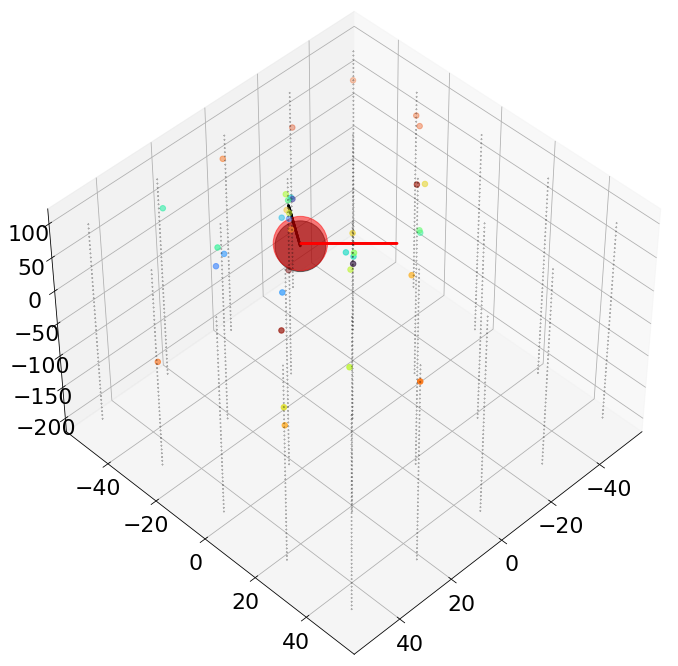

In [770]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
segments = model(*truth, step=0.1)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='r', alpha=0.5)
segments = model(*reco, step=0.1)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='k', alpha=0.5)
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)

In [759]:
def generate_events(N, detector):
    #sample truth
    truths = np.random.rand(N, 8)
    truths[:, :2] = (truths[:, :2] - 0.5) * 140
    truths[:, 2] = (truths[:, 2] - 2/3) * 400
    truths[:, 3] = (truths[:, 3] - 0.5) * 1000
    truths[:, 4] *= 2*np.pi
    truths[:, 5] = np.arccos(2*truths[:, 5] -1)
    truths[:, 6] = - np.log(truths[:, 6]) * 10
    truths[:, 7] = - np.log(truths[:, 7]) * 10
    
    events = []
    for i in tqdm(range(N)):
        hits, n_obs = generate(truths[i], detector)
        events.append([np.array([np.sum(n_obs), np.sum(n_obs > 0)]), hits])
        
    return np.array(events, dtype='O'), truths

In [762]:
%%time
events, truths = generate_events(1_000, detector)

100%|██████████| 1000/1000 [00:05<00:00, 195.14it/s]

CPU times: user 4.96 s, sys: 60.5 ms, total: 5.02 s
Wall time: 5.13 s


In [114]:
np.save('../resources/toy_data/toy_detector_philipp_test', detector)
np.save('../resources/toy_data/toy_events_philipp_test', events)
np.save('../resources/toy_data/toy_truth_philipp_test', truths)